**МОДЕЛИРОВАНИЕ ВРЕМЕННЫХ РЯДОВ**


При написании программы моделирования необходимо помнить о логических правилах, определяющих поведение системы. Ниже рассматривается пример программы, в которой выполняется жесткая проверка логической целостности данных (например, из системы исключаются события, которые противоречат ее логике).

In [1]:
import pandas as pd
import numpy as np
import random


In [2]:
years = ['2014', '2015', '2016', '2017', '2018']
memberStatus = ['bronze', 'silver', 'gold', 'inactive']
memberYears = np.random.choice(years, 1000, p = [0.1, 0.1, 0.15, 0.30, 0.35])
memberStats = np.random.choice(memberStatus, 1000, p = [0.5, 0.3, 0.1, 0.1])
yearJoined = pd.DataFrame({'yearJoined': memberYears, 'memberStats': memberStats})


Мы можем усложнить поведенческие правила, корректируя отдельные параметры модели в зависимости от принятия старых или создания новых предположений о ненаблюдаемых процессах, влияющих на данные.

In [3]:
NUM_EMAILS_SENT_WEEKLY = 3
## Определение функций для разных поведенческих шаблонов
def never_opens (period_rng):
    return[ ]

def constant_open_rate(period_rng):
    n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
    num_opened = np.random.binomial (n, p, len(period_rng))
    return num_opened

def increasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(1.01, 1.30))

def decreasing_open_rate (period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(0.5, 0.99))

def open_rate_with_factor_change (period_rng, fac):
    if len(period_rng) < 1:
        return[ ]
    times = np.random.randint(0, len(period_rng), int(0.1 * len(period_rng)))
    num_opened = np.zeros(len (period_rng))
    for prd in range(0, len(period_rng), 2):
        try:
            n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
            num_opened[prd:(prd + 2) ] = np.random.binomial(n, p, 2)
            p = max (min (1, p * fac), 0)
        except:
            num_opened[prd] = np.random.binomial(n, p, 1)
        for t in range(len(times)):
            num_opened[times[t]] = 0
        return num_opened

Далее нам нужно определиться с моделью внесения добровольных пожертвований. Она не должна быть слишком простой, иначе это приведет к неправильному пониманию описываемых процессов. Другими словами, в модель внесения пожертвований нужно включить текущие предположения о поведении членов организации, а затем проверить, соответствуют ли они модели и наблюдениям, представленным реальными данными. Ниже приведен код описания процесса внесения пожертвований, находящегося в слабой зависимости от количества писем, открываемых членом организации в течение недели.

In [4]:
def produce_donations(period_rng, member_behavior, num_emails,use_id, member_join_year):
    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500, 1000, 1500, 2000])
    member_has = np.random.choice(donation_amounts)
    email_fraction = num_emails/(NUM_EMAILS_SENT_WEEKLY * len(period_rng))
    member_gives = member_has * email_fraction
    member_gives_idx = np.where(member_gives >= donation_amounts) [0][-1]
    member_gives_idx = max (min (member_gives_idx, len(donation_amounts) - 2), 1)
    num_times_gave = np.random.poisson (2) * (2018 - member_join_year)
    times = np.random.randint(0, len(period_rng), num_times_gave)
    dons = pd.DataFrame ({'member': [], 'amount': [ ], 'timestamp': [ ]})
    for n in range (num_times_gave) :
        donation = donation_amounts[member_gives_idx+ np.random.binomial (1, .3)]
        ts = str(period_rng [times [n] ] .start_time + random_weekly_time_delta())
        dons = dons.append(pd.DataFrame({'member' : [use_id],'amount' : [donation],'timestamp': [ts]}))
        if dons. shape [0] > 0:
            dons = dons [dons. amount != 0]
## Нулевые пожертвования не указываются, поскольку
## в реальной базе данных они не регистрируются
    return dons


Поскольку поведение наших участников строго фиксируется по временным меткам, каждому члену организации нужно определить неделю и день внесения пожертвований. Напишем вспомогательную функцию выбора случайного времени в течение недели.


In [5]:
def random_weekly_time_delta () :
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11, 23)]
    minute_of_hour = [m for m in range (60)]
    second_of_minute = [s for s in range (60)]
    return pd.Timedelta(str(np.random.choice(days_of_week)) + "days") +pd.Timedelta (str(np.random.choice(hours_of_day)) + "hours" ) +pd.Timedelta(str(np.random.choice(minute_of_hour)) + "minutes") +pd.Timedelta(str(np.random.choice(second_of_minute)) + "seconds")


Наконец, нам нужно объединить все компоненты модели и смоделировать поведение определенного количества членов организации и соответствующих событий, возникающих только вследствие получения членства в организации, таким образом, чтобы обеспечить некоторое (но не пренебрежимо малое) влияние событий просмотра электронной почты на события внесения пожертвований.

In [6]:
behaviors = [never_opens,constant_open_rate,increasing_open_rate,decreasing_open_rate]
member_behaviors = np.random.choice(behaviors, 1000, [0.2, 0.5, 0.1, 0.2])
rng = pd.period_range('2015-02-14', '2018-06-01', freq = 'W')
emails = pd.DataFrame ({'member': [],'week': [ ],'emailsOpened': [ ]})
donations = pd.DataFrame({'member' : [],'amount' : [ ],'timestamp' : [ ] })
for idx in range(yearJoined.shape[0]):
## Генерирование случайного момента получения членства в организации
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined) + pd.Timedelta(str(np.random.randint(0, 365)) + 'days')
    join_date = min(join_date, pd.Timestamp('2018-06-01'))

## До вступления в организацию временные метки не предусмотрены
    member_rng = rng[rng.to_timestamp() > join_date]
    if len(member_rng) < 1:
        continue
    info = member_behaviors [idx] (member_rng)
    if len(info) == len (member_rng) :
        emails = emails.append(pd.DataFrame({'member': [idx] * len(info),'week': [str(r. start_time) for r in member_rng],'emailsOpened' : info}))
        donations = donations.append(produce_donations(member_rng, member_behaviors[idx],sum(info), idx, join_date.year))


Выходные данные были обрезаны до нескольких последних строк (5000).
<ipython-input-6-41ab433be316>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  donations = donations.append(produce_donations(member_rng, member_behaviors[idx],sum(info), idx, join_date.year))
<ipython-input-6-41ab433be316>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emails = emails.append(pd.DataFrame({'member': [idx] * len(info),'week': [str(r. start_time) for r in member_rng],'emailsOpened' : info}))
<ipython-input-4-1a9c32aee5a0>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dons = dons.append(pd.DataFrame({'member' : [use_id],'amount' : [donation],'timestamp': [ts]}))
<ipython-input-4-1a9c32aee5a0>:14: FutureWarning: The frame.append method

Отобразим общую сумму ежемесячных добровольных пожертвований, вычисленных из набора данных

<Axes: xlabel='timestamp'>

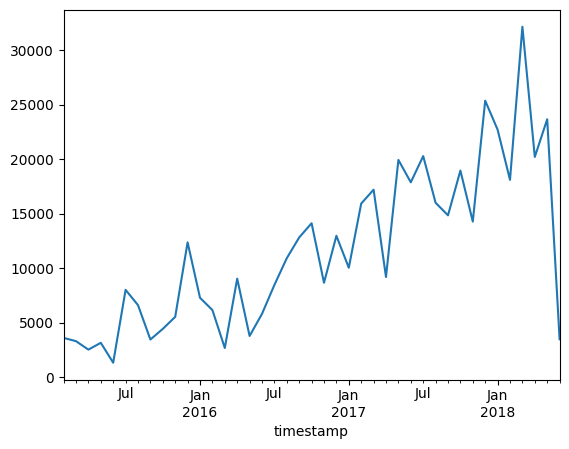

In [8]:
df = pd.read_csv('donations.csv')
df.set_index(pd.to_datetime(df.timestamp), inplace = True)
df.sort_index(inplace = True)
df.groupby(pd.Grouper(freq= 'M')).amount.sum().plot()

**Создание самоуправляемой среды моделирования**

Рассмотрим метод, используемый мною для получения идентификационного номера такси.

In [9]:
def taxi_id_number(num_taxis):
    arr = np.arange(num_taxis)
    np.random.shuffle(arr)
    for i in range(num_taxis) :
        yield arr[i]

ids = taxi_id_number(10)
print (next (ids))
print (next (ids))
print (next (ids))


6
5
1


In [10]:
def shift_info () :
    start_times_and_freqs = [(0, 8), (8, 30), (16, 15)]
    indices = np.arange(len(start_times_and_freqs))
    while True:
        idx = np.random.choice (indices, p = [0.25, 0.5, 0.25])
        start = start_times_and_freqs[idx]
        yield (start[0], start[0] + 7.5, start [1])


 Перейдем к написанию более сложного генератора, в котором предыдущие генераторы используются для установки индивидуальных параметров и расписания такси.

In [11]:
def taxi_process(taxi_id_generator, shift_info_generator) :
    taxi_id = next(taxi_id_generator)
    shift_start, shift_end, shift_mean_trips = next(shift_info_generator)
    actual_trips = round(np.random.normal (loc = shift_mean_trips, scale = 2))
    average_trip_time = 6.5/shift_mean_trips*60
# Среднее время поездки в минутах
    between_events_time = 1.0/(shift_mean_trips - 1)*60
# Город, в котором такси освобождается от клиента
    time = shift_start
    yield TimePoint(taxi_id, 'start shift', time)
    deltaT = np.random.poisson(between_events_time) / 630
    time += deltaT
    for i in range (actual_trips) :
        yield TimePoint(taxi_id, 'pick up ', time)
        deltaT = np.random.poisson(average_trip_time) / 60
        time += deltaT
        yield TimePoint(taxi_id, 'drop off ', time)
        deltaT = np.random.poisson(between_events_time) / 60
        time += deltaT
    deltaT = np.random.poisson(between_events_time) / 60
    time += deltaT
    yield TimePoint (taxi_id, 'end shift ', time)


Генератор такси возвращает объекты класса TimePoint, которые определяются следующим образом.

In [12]:
from dataclasses import dataclass
@dataclass
class TimePoint:
    taxi_id: int
    name: str
    time: float

    def __It__ (self, other) :
         return self.time < other.time


Итак, мы располагаем классом моделирования для настройки и запуска генераторов такси. Это нестандартный класс, поскольку обладает специальными функциями — в том числе заданными в инициализаторе — представления входных данных в виде понятной структуры данных и дальнейшей их обработки.

In [13]:
import queue

class Simulator:
    def __init__(self, num_taxis) :
        self.time_points = queue.PriorityQueue()
        taxi_id_generator = taxi_id_number(num_taxis)
        shift_info_generator = shift_info()
        self.taxis = [taxi_process(taxi_id_generator,shift_info_generator) for i in range(num_taxis)]
        self.prepare_run()

    def prepare_run(self) :
        for t in self.taxis:
            while True:
                try:
                    #e = next(t)
                    self.time_points.put(t)
                except:
                    break

    def run(self) :
        sim_time = 0
        while sim_time < 24:
            if self.time_points.empty():
                break
            self.time_points.join()
            p = self.time_points.get()
            sim_time = p.time
            print(p.time)



In [ ]:
sim = Simulator(1000)
sim.time_points.empty()
sim.run()



**Моделирование физических процессов**

Рассмотрим детали реализации модели Изинга. Представим материал, состоящий из множества объектов, расположенных в узлах двумерной сетки, каждый из которых обладает магнитным моментом (спином), характеризующимся направлением поля вверх или вниз. В начальный момент времени направление поля у всех объектов выбирается случайным образом. Нам нужно описать эволюцию системы таких объектов из случайного состояния в наиболее упорядоченное состояние, происходящую при низкой температуре (модель Изинга чаще используется для описания равновесных состояний ферромагнитных материалов, а не для изучения временных аспектов их перехода в состояние равновесия.

In [ ]:
N = 5 # ширина сетки
M = 5 # высота сетки
## Установка температуры
temperature = 0.5
BETA = 1/temperature


Для случайной инициализации стартового блока обратимся к служебным методам.

In [ ]:
def initRandState (N, М) :
    block = np.random.choice ([-1, 1], size = (N, M) )
    return block


Кроме того, нам нужно вычислить энергию выравнивания центрального блока относительно его соседей.

In [ ]:
def costForCenterState(state, i, j, n, m) :
    centers = state[i, j]
    neighbors = [ ( (i + 1) % n, j), ((i - 1) % n, j), (i, (j + 1) % m), (i, (j - 1) % m) ]
## Обратите внимание на использование аргумента % n,
## указывающего на периодичность условия.
## Игнорируйте его, если в нем нет необходимости, -
## это всего лишь физическое ограничение для двумерных
## систем, которые можно описать через поверхность тора
    interactionE = [state[х, у] * centers for (х, у) in neighbors]
    return np.sum(interactionE)


Определим намагниченность всего блока в данном состоянии.

In [ ]:
def magnetizationForState(state) :
    return np.sum(state)


Этапы моделирования процесса по методу МСМС, рассматриваемому ранее, реализуются следующим образом.

In [ ]:
def mcmcAdjust(state, BETA=2) :
    n = state.shape[0]
    m = state.shape[1]
    x = np.random.randint(0, n)
    y = np.random.randint(0, m)
    centers = state[x, y]
    cost = costForCenterState(state, x, y, n, m)
    if cost < 0:
        centers *= -1
    elif np.random.random() < np.exp(-cost * BETA):
        centers *= -1
    state [x, y] = centers
    return state


Для запуска процесса моделирования нам потребуются функции регистрации данных и перенастройки модели МСМС.

In [ ]:
def runState (state, n_steps, snapsteps = None):
    if snapsteps is None:
        snapsteps = np.linspace(0, n_steps, num = round(n_steps /(M * N * 100) ),dtype = np.int32)
    saved_states = []
    sp = 0
    magnet_hist = []
    for i in range(n_steps) :
        state = mcmcAdjust(state)
        magnet_hist.append(magnetizationForState(state))
        if sp < len (snapsteps) and i == snapsteps[sp]:
            saved_states.append(np.copy(state))
        sp += 1
    return state, saved_states, magnet_hist


Запуск моделирования

In [ ]:
#МОДЕЛИРОВАНИЕ
init_state = initRandState(N, M)
print (init_state)
final_state = runState(np.copy(init_state), 1000)


[[-1 -1  1 -1  1]
 [-1  1  1  1  1]
 [-1 -1  1  1 -1]
 [-1  1  1  1 -1]
 [-1  1  1  1  1]]


Определим намагниченность материала в разные моменты времени для большого количества независимых сеансов моделирования

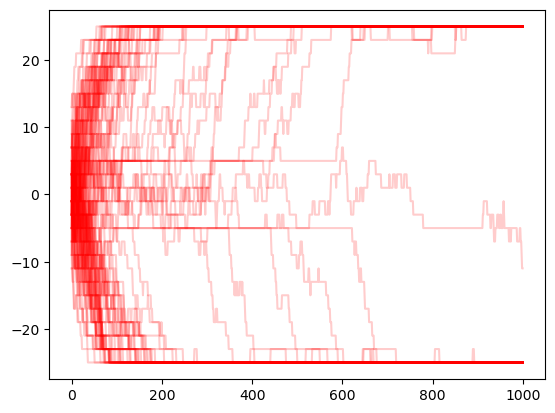

In [ ]:
import matplotlib
## Каждый временной ряд представляет отдельный результат
results = []
for i in range (100) :
    init_state = initRandState (N, M)
    final_state, states, magnet_hist = runState(init_state, 1000)
    results.append(magnet_hist)

## Построение графиков каждого ряда для оценки их перекрываемости
for mh in results:
    matplotlib.pyplot.plot(mh, 'r', alpha=0.2)


### Полученные результаты можно использовать в дальнейших исследованиях подобно тому, как это было сделано при моделировании поведения таксопарка.  ###
### • Настройки конвейера данных на основе сгенерированных в результате моделирования временных рядов ###
### • Тестирование методов машинного обучения на синтезированных данных для изучения возможности их применения к собираемым данным до очистки и предварительной обработки ###
### • Изучение важных характеристик физической модели для лучшего понимания базовой системы. ###
